In [1]:
!pip install numpy
!pip install pandas
!pip install tensorflow

In [2]:
import numpy as np
import pandas as pd
import os
import re
import string
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

In [3]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Dosya yolunu kontrol etme ve yazdırma

In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Veri setini yükleme

In [5]:
df = pd.read_csv("/content/turkish_movie_sentiment_dataset.csv")

# Yorumları temizleme fonksiyonu

In [6]:
def clean_comment(comment):
    comment = comment.lower()
    comment = remove_punctuation(comment)
    comment = comment.replace("\r", " ").replace("\n", " ")
    comment = remove_numeric(comment)
    return comment

# Noktalama işaretlerini kaldırma fonksiyonu

In [7]:
def remove_punctuation(text):
    no_punc = [char for char in text if char not in string.punctuation]
    word_wo_punc = "".join(no_punc)
    return word_wo_punc

# Sayıları kaldırma fonksiyonu

In [8]:
def remove_numeric(text):
    output = "".join([char for char in text if not char.isdigit()])
    return output

# Yorumları ve puanları temizleme

In [9]:
comments = lambda x : x[23:-24]
df["comment"] = df["comment"].apply(comments)
floatize = lambda x : float(x[0:-2])
df["point"] = df["point"].apply(floatize)


# Puanları ikili sınıfa dönüştürme

In [10]:
df.drop(df[df["point"] == 3].index, inplace=True)
df["point"] = df["point"].replace([1, 2], 0)
df["point"] = df["point"].replace([4, 5], 1)

# Yorumları temizleme

In [11]:
df["comment"] = df["comment"].apply(clean_comment)

# Veri setini eğitim ve test olarak ayırma

In [12]:
target = df["point"].values.tolist()
data = df["comment"].values.tolist()

In [13]:
cutoff = int(len(data) * 0.80)
X_train, X_test = data[:cutoff], data[cutoff:]
y_train, y_test = target[:cutoff], target[cutoff:]


# Tokenizer ile kelime indekslerini oluşturma

In [14]:
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(data)
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

# Padding işlemi

In [15]:
num_tokens = [len(tokens) for tokens in X_train_tokens + X_test_tokens]
num_tokens = np.array(num_tokens)
max_tokens = int(np.mean(num_tokens) + 2 * np.std(num_tokens))
X_train_pad = pad_sequences(X_train_tokens, maxlen=max_tokens)
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_tokens)

# Modeli oluşturma ve eğitme

In [17]:
embedding_size = 50
model = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_size, input_length=max_tokens, name="embedding_layer"),
    GRU(units=16, return_sequences=True),
    GRU(units=8, return_sequences=True),
    GRU(units=4),
    Dense(1, activation="sigmoid")
])
optimizer = Adam(learning_rate=1e-3)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding  (None, 141, 50)           500000    
 )                                                               
                                                                 
 gru (GRU)                   (None, 141, 16)           3264      
                                                                 
 gru_1 (GRU)                 (None, 141, 8)            624       
                                                                 
 gru_2 (GRU)                 (None, 4)                 168       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 504061 (1.92 MB)
Trainable params: 504061 (1.92 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [18]:
X_train_pad = np.array(X_train_pad)
y_train = np.array(y_train)
model.fit(X_train_pad, y_train, epochs=5, batch_size=256)

Epoch 1/5
215/215 [==============================] - 52s 214ms/step - loss: 0.5221 - accuracy: 0.7593
Epoch 2/5
215/215 [==============================] - 46s 216ms/step - loss: 0.4020 - accuracy: 0.8359
Epoch 3/5
215/215 [==============================] - 48s 222ms/step - loss: 0.3635 - accuracy: 0.8572
Epoch 4/5
215/215 [==============================] - 46s 214ms/step - loss: 0.3369 - accuracy: 0.8738
Epoch 5/5
215/215 [==============================] - 48s 221ms/step - loss: 0.3127 - accuracy: 0.8870


# Yorumun duygu analizini yapma fonksiyonu

In [19]:
def sentiment_analysis_single_comment(comment):
    comment = clean_comment(comment)
    tokens = tokenizer.texts_to_sequences([comment])
    tokens_pad = pad_sequences(tokens, maxlen=max_tokens)
    prediction = model.predict(tokens_pad)[0][0]
    sentiment = "Pozitif" if prediction > 0.5 else "Negatif"
    return sentiment, prediction

# Tüm yorumların duygu analizini yapma fonksiyonu

In [20]:
def sentiment_analysis_all_comments(data):
    sentiments = []
    for comment in data:
        sentiment, prediction = sentiment_analysis_single_comment(comment)
        sentiments.append(sentiment)
    positive_comments = sentiments.count("Pozitif")
    negative_comments = sentiments.count("Negatif")
    return positive_comments, negative_comments

# Seçilen bir yorumu analiz et

In [23]:
selected_comment = X_test[15]
sentiment, prediction = sentiment_analysis_single_comment(selected_comment)
print(f"Seçilen yorum: {selected_comment}")
print(f"Duygu analizi sonucu: {sentiment} (Tahmin: {prediction})")

1/1 [==============================] - 0s 37ms/step
Seçilen yorum: her iki başrolde son yıllardaki düşüşüne devam ederfilmi izleyeceğim tabiki ama hiç beklentim yok maalesef
Duygu analizi sonucu: Pozitif (Tahmin: 0.8671247959136963)


# Genel olarak tüm yorumları analiz et

In [24]:
positive_comments, negative_comments = sentiment_analysis_all_comments(X_test)
print(f"Pozitif yorum sayısı: {positive_comments}")
print(f"Negatif yorum sayısı: {negative_comments}")

Görüntülenen çıkış son 5000 satıra kısaltıldı.
1/1 [==============================] - 0s 52ms/step
Pozitif yorum sayısı: 6107
Negatif yorum sayısı: 7640


# En sık kullanılan kelimeleri görselleştirme

In [25]:
all_comments = " ".join(data)
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_comments)


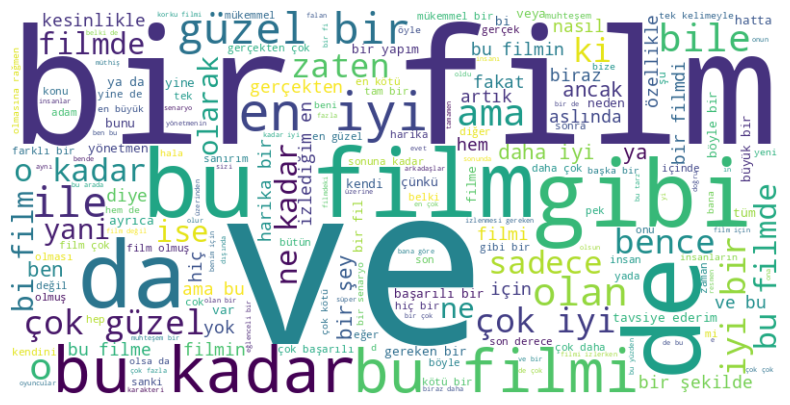

In [26]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# En sık kullanılan 10 kelimeyi listeleme

In [27]:
word_counts = Counter(all_comments.split())
common_words = word_counts.most_common(10)
print("En sık kullanılan 10 kelime:", common_words)

En sık kullanılan 10 kelime: [('bir', 105869), ('ve', 56785), ('film', 49399), ('bu', 47146), ('çok', 38835), ('filmi', 22797), ('de', 22279), ('ama', 21383), ('da', 18371), ('iyi', 18292)]


# Kullanıcıdan bir film adı girişi alalım

In [69]:
film_name = input("Analiz yapmak istediğiniz filmin adını girin: ")

Analiz yapmak istediğiniz filmin adını girin: Tek Başına


# Sütun adlarını kontrol etme

In [70]:
print(df.columns)

Index(['comment', 'film_name', 'point'], dtype='object')


# Seçilen film için yorumları filtreleyelim

In [71]:
film_yorumlari = df[df["film_name"] == film_name]


# Eğer seçilen film için yorum yoksa bir hata mesajı verelim

In [72]:
if film_yorumlari.empty:
    print(f"{film_name} için yorum bulunamadı.")
else:
    # Yorumları ve puanları alalım
    film_yorumlari_text = film_yorumlari["comment"].values
    film_yorumlari_point = film_yorumlari["point"].values

# Yorumları tokenize edelim

In [73]:

    film_yorumlari_tokens = tokenizer.texts_to_sequences(film_yorumlari_text)
    film_yorumlari_pad = pad_sequences(film_yorumlari_tokens, maxlen=max_tokens)

# Modeli kullanarak tahmin yapalım

In [74]:
    film_yorumlari_pred = model.predict(film_yorumlari_pad)
    film_yorumlari_pred = film_yorumlari_pred.T[0]
    film_yorumlari_pred_cls = np.array([1.0 if p > 0.5 else 0.0 for p in film_yorumlari_pred])


1/1 [==============================] - 0s 41ms/step


# Pozitif ve negatif yorumları sayalım

In [75]:
    pozitif_yorum_sayisi = np.sum(film_yorumlari_pred_cls == 1.0)
    negatif_yorum_sayisi = np.sum(film_yorumlari_pred_cls == 0.0)

# Sonuçları yazdıralım

In [76]:
    print(f"{film_name} için toplam {len(film_yorumlari)} yorum bulundu.")
    print(f"Pozitif yorum sayısı: {pozitif_yorum_sayisi}")
    print(f"Negatif yorum sayısı: {negatif_yorum_sayisi}")

Tek Başına için toplam 16 yorum bulundu.
Pozitif yorum sayısı: 13
Negatif yorum sayısı: 3


In [77]:
    if pozitif_yorum_sayisi > negatif_yorum_sayisi:
        print(f"{film_name} genel olarak iyi bir film.")
    else:
        print(f"{film_name} genel olarak kötü bir film.")

Tek Başına genel olarak iyi bir film.
